# Predicting lower back pain with R
We are going to have an explore of this data and then predict lower back pain using these biometric measurements; this is a **binary classification** problem, as we have two outcomes: *abnormal* and *normal*. 

There are many ways that we can approach a classification problem, and there are many algorithms that can be used to create predictions. In this report I use logistic regression, support vector machines and random forests. I compare the accuracies, and provide a method for looking at other predictive metrics and what they mean. I use the `caret` package to apply cross-validation to the data set to provide a better look at what the out-of-sample predictive power of the models is, and allow for comparative performance through sharing a `trainControl`. 

If you have any suggestions for improvements, or where I might be able to go next, then I would love to hear from you. Happy reading! 

## Exploration and data loading
Let's start with loading the data that we have and getting a feel for the structure. 

In [1]:
# Load packages
library(tidyverse)
library(readr)

# Load the data 
data <- readr::read_csv('./data/Dataset_spine.csv')
head(data)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“Missing column names filled in: 'X14' [14]”Parsed with column specification:
cols(
  Col1 = col_double(),
  Col2 = col_double(),
  Col3 = col_double(),
  Col4 = col_double(),
  Col5 = col_double(),
  Col6 = col_double(),
  Col7 = col_double(),
  Col8 = col_double(),
  Col9 = col_double(),
  Col10 = col_double(),
  Col11 = col_double(),
  Col12 = col_double(),
  Class_att = col_character(),
  X14 = col_character()
)


Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,X14
63.02782,22.552586,39.60912,40.47523,98.67292,-0.254400,0.7445035,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NA
39.05695,10.060991,25.01538,28.99596,114.40543,4.564259,0.4151857,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NA
68.83202,22.218482,50.09219,46.61354,105.98514,-3.530317,0.4748892,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classification.
69.29701,24.652878,44.31124,44.64413,101.86850,11.211523,0.3693453,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NA
49.71286,9.652075,28.31741,40.06078,108.16872,7.918501,0.5433605,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NA
40.25020,13.921907,25.12495,26.32829,130.32787,2.230652,0.7899929,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal,Attribute1 = pelvic_incidence (numeric)


We should note that there are no column names in the csv file itself, so we could add those manually using the information that has been provided with the dataset. 

We can also see that we have 12 numeric columsn, and 2 character columns; the 12 numeric/double columns represent those features that we are going to use to make our predictions, while the 2 character columns represent our classes, and further notes. 

Now that we have read in our data, we should begin with the usual exploratory analysis and visualisations to get a *feel* for the data, and an idea about which featuers may act as good indicators of lower back pain. 

We only have 310 observations, which is a very small sample; it does mean that we aren't going to suffer too heavily with computational issues when training our models. However, with such a small sample size, we probably can't be certain about how well our results would extend to new cases. 

In [2]:
# Type cast the classification column
data$Class_att <- as.factor(data$Class_att)

# Summarise our data 
summary(data)

      Col1             Col2             Col3             Col4       
 Min.   : 26.15   Min.   :-6.555   Min.   : 14.00   Min.   : 13.37  
 1st Qu.: 46.43   1st Qu.:10.667   1st Qu.: 37.00   1st Qu.: 33.35  
 Median : 58.69   Median :16.358   Median : 49.56   Median : 42.40  
 Mean   : 60.50   Mean   :17.543   Mean   : 51.93   Mean   : 42.95  
 3rd Qu.: 72.88   3rd Qu.:22.120   3rd Qu.: 63.00   3rd Qu.: 52.70  
 Max.   :129.83   Max.   :49.432   Max.   :125.74   Max.   :121.43  
      Col5             Col6              Col7              Col8       
 Min.   : 70.08   Min.   :-11.058   Min.   :0.00322   Min.   : 7.027  
 1st Qu.:110.71   1st Qu.:  1.604   1st Qu.:0.22437   1st Qu.:13.054  
 Median :118.27   Median : 11.768   Median :0.47599   Median :21.907  
 Mean   :117.92   Mean   : 26.297   Mean   :0.47298   Mean   :21.322  
 3rd Qu.:125.47   3rd Qu.: 41.287   3rd Qu.:0.70485   3rd Qu.:28.954  
 Max.   :163.07   Max.   :418.543   Max.   :0.99883   Max.   :36.744  
      Col9          

A quick glimpse over the data shows us that we have 12 numeric columns across varying scales, and magnitudes. If we are going to use a KNN approach it is definitely going to be necessary to normalise the features so that no one feature has more weight over the classfication. 

We can also see that we have a split of 210/100 for abnormal/normal. This shouldn't be an issue, and is certainly a welcome change from the small count rare events that are often associated with binary classification problems. 

We can also see that we don't have any `NA` values in oru numeric columns, so we won't be required to do any imputation or cleaning where that is concerned. This can be confirmed with a little `NA` check. 

In [3]:
sapply(data, FUN = function(col) sum(is.na(col)))

Col1      Col2      Col3      Col4      Col5      Col6      Col7      Col8 
        0         0         0         0         0         0         0         0 
     Col9     Col10     Col11     Col12 Class_att       X14 
        0         0         0         0         0       296

In [4]:
# install.packages('GGally')
library(GGally)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



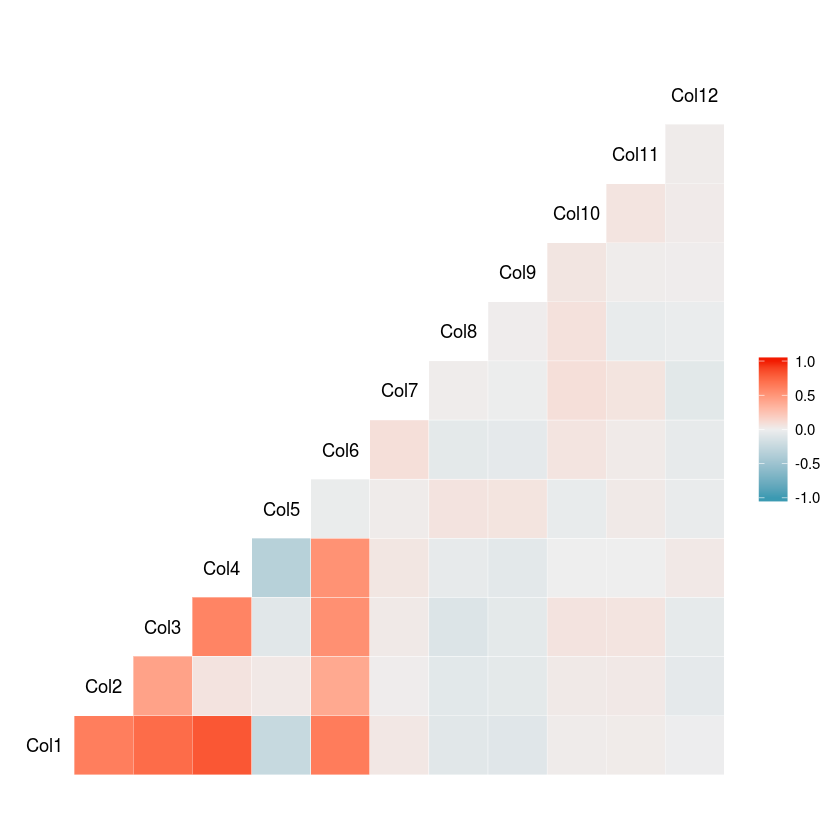

In [5]:
# Remove non-numeric columns before observing correlations between variables
data %>% select_if(is.numeric) %>% ggcorr()

I think this is a good starting point to get an idea of how these variable are connected. We can see that there is definitely some correlation between the variables `Col1` - `Col4` which may be more obvious why when I add the column names from the meta data. This highlights the possibility for colinearity later in the analysis that we should be aware of, and perhaps for the fact that we might not need to use all of those variables as predictors. 

The other columns don't seem to be correlated with one another, or at least not strongly. So what matters next is how they are related to the response variable. 

If we look closer at our 14th column, we will see that this is actually being used to hold information about the other columns and what they represent. 

In [6]:
unique(data$X14)

[1] NA                                                  
 [2] "Prediction is done by using binary classification."
 [3] "Attribute1  = pelvic_incidence  (numeric)"         
 [4] "Attribute2 = pelvic_tilt (numeric)"                
 [5] "Attribute3 = lumbar_lordosis_angle (numeric)"      
 [6] "Attribute4 = sacral_slope (numeric)"               
 [7] "Attribute5 = pelvic_radius (numeric)"              
 [8] "Attribute6 = degree_spondylolisthesis (numeric)"   
 [9] "Attribute7= pelvic_slope(numeric)"                 
[10] "Attribute8= Direct_tilt(numeric)"                  
[11] "Attribute9= thoracic_slope(numeric)"               
[12] "Attribute10= cervical_tilt(numeric)"               
[13] "Attribute11=sacrum_angle(numeric)"                 
[14] "Attribute12= scoliosis_slope(numeric)"             
[15] "Attribute class {Abnormal, Normal}"

In [7]:
# Assign the new column names using data from `X14`
data <- data %>% 
    rename('pelvic_incidence' = Col1, 
           'pelvic_tilt' = Col2, 
           'lumbar_lordosis_angle' = Col3,
           'sacral_slope' = Col4, 
           'pelvic_radius' = Col5, 
           'degree_spondylolisthesis' = Col6, 
           'pelvic_slope' = Col7, 
           'direct_tilt' = Col8, 
           'thoracic_slope' = Col9, 
           'cervical_tilt' = Col10, 
           'sacrum_angle' = Col11, 
           'scoliosis_slope' = Col12) %>%
    select(-X14)

head(data)

pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
63.02782,22.552586,39.60912,40.47523,98.67292,-0.254400,0.7445035,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
39.05695,10.060991,25.01538,28.99596,114.40543,4.564259,0.4151857,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
68.83202,22.218482,50.09219,46.61354,105.98514,-3.530317,0.4748892,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
69.29701,24.652878,44.31124,44.64413,101.86850,11.211523,0.3693453,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
49.71286,9.652075,28.31741,40.06078,108.16872,7.918501,0.5433605,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal
40.25020,13.921907,25.12495,26.32829,130.32787,2.230652,0.7899929,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal


In [8]:
# Reshape the data for plotting
data_long <- data %>%
    gather('feature', 'value', -Class_att)

head(data_long)

Class_att,feature,value
Abnormal,pelvic_incidence,63.02782
Abnormal,pelvic_incidence,39.05695
Abnormal,pelvic_incidence,68.83202
Abnormal,pelvic_incidence,69.29701
Abnormal,pelvic_incidence,49.71286
Abnormal,pelvic_incidence,40.25020


Transforming the data in this way allows for a simple plot and means that we can make use of the facetting capabilites of `ggplot2`.

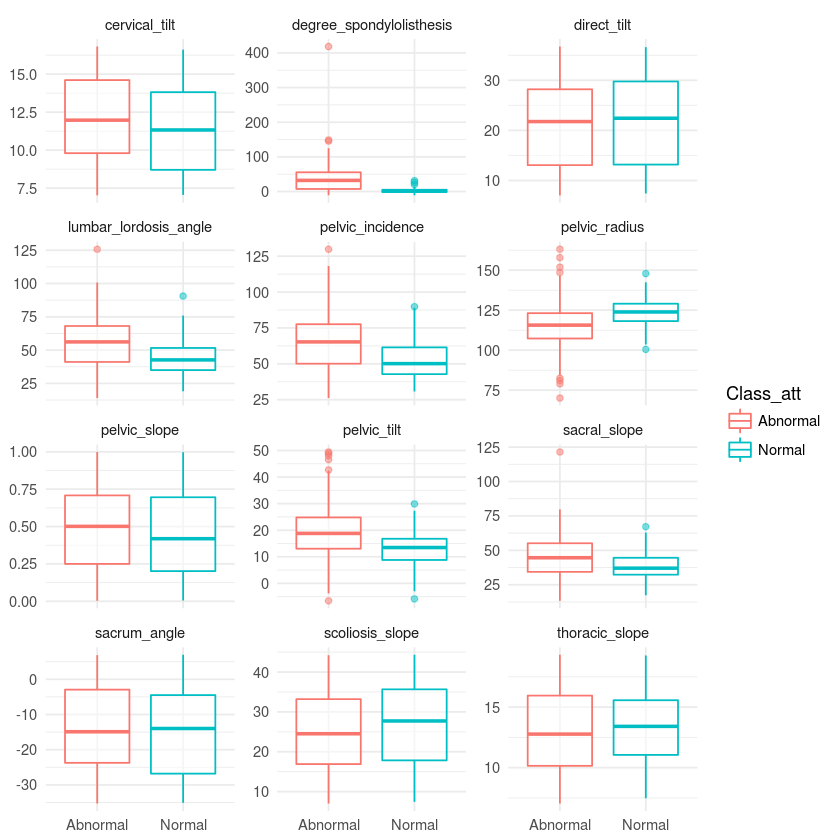

In [9]:
data_long %>%
    ggplot(aes(Class_att, value, colour = Class_att)) + 
        geom_boxplot(alpha = 0.5) + 
        facet_wrap(~ feature, scales='free_y', ncol = 3) + 
        labs(x = NULL, y = NULL) + 
        theme_minimal()

I find this is a good way to visualise the differences of each feature and our outcome class. Another alternative is to look at the difference in the distributions by using `geom_density`, which I have done below.  

**Note**: In the above code I have used `free_y` on the scales as our variables aren't all using the same magnitude of values, so freeing the y axis range allows us to compare the individual variables much more easily. 



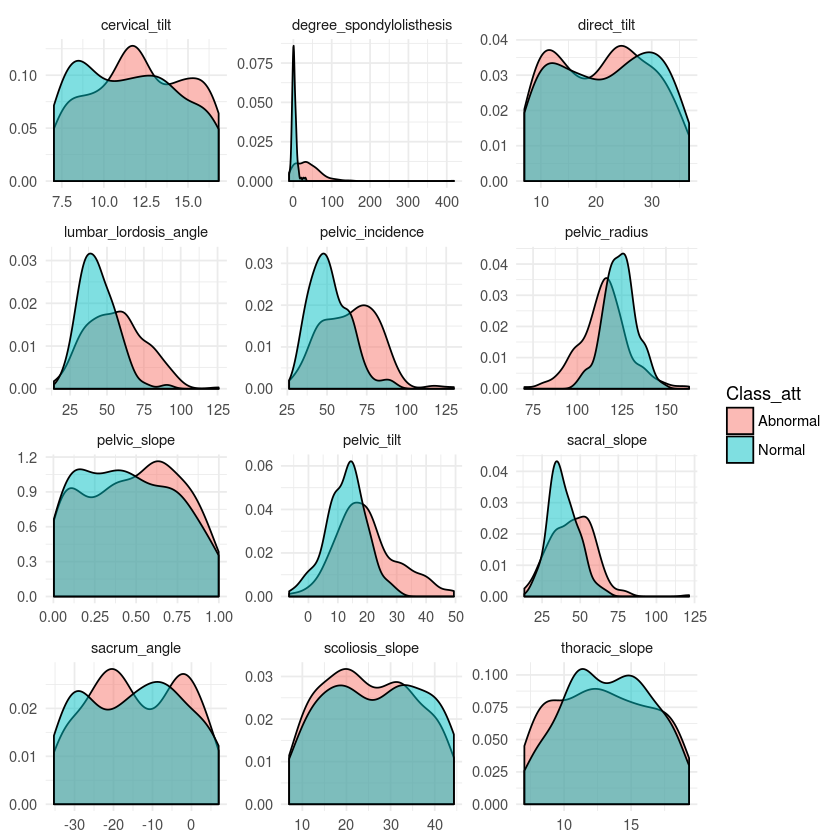

In [10]:
data_long %>%
    ggplot(aes(value, fill = Class_att)) + 
        geom_density(alpha = 0.5) + 
        facet_wrap(~ feature, scales='free', ncol = 3) + 
        labs(x = NULL, y = NULL) + 
        theme_minimal()

Looking at the information using the `geom_density` provides more information about the differences between these values and the outcome variable. We are looking for two more distinct populations between the *normal* observations and the *abnormal* as these would be the features that grant us the most predictive power. 

If those that differ the most between *normal* and *abnormal* are also highly correlated with one another then we may have found a good set of indicators that lead to lower back pain; the colinearity between the values most associated with the lower back pain could represent a single condition/issue. 

We can also look at this by doing some calculations, and see by how much the values differ between the two classes of `Class_att`.  Doing this we can put a numeric value on the difference between the average values for each of our variables. 

In [11]:
data_long %>%
    group_by(feature, Class_att) %>%
    summarise(mean = mean(value)) %>%
    spread(Class_att, mean) %>% # Spread the data to make the table 'wide'
    mutate(Diff = Abnormal - Normal, 
           `Percentage Difference` = (Abnormal - Normal) / Normal * 100) %>%
    arrange(desc(abs(`Percentage Difference`))) # Arrange by the largest differences, accounting for negatives

feature,Abnormal,Normal,Diff,Percentage Difference
degree_spondylolisthesis,37.7777051,2.1865721,35.5911330,1627.713701
pelvic_tilt,19.7911113,12.8214143,6.9696970,54.359815
lumbar_lordosis_angle,55.9253700,43.5426048,12.3827651,28.438274
pelvic_incidence,64.6925617,51.6852444,13.0073173,25.166404
sacral_slope,44.9014504,38.8638301,6.0376203,15.535320
pelvic_slope,0.4839788,0.4498803,0.0340985,7.579462
pelvic_radius,115.0777125,123.8908343,-8.8131218,-7.113619
scoliosis_slope,25.1469148,26.6940190,-1.5471042,-5.795696
cervical_tilt,12.1327370,11.5145342,0.6182028,5.368891
sacrum_angle,-13.8266766,-14.5287115,0.7020349,-4.832052


We observe the differences between the *Abormal* and *Normal* mean average observations. As the units and magnitudes for the measurements are differing between the variables, we calculate the difference via a percentage to make them more easily comparable. We can see that `degree_spondylolisthesis` is, on average, much larger in sufferers than it is in non-sufferers. `pelvic_tilt` is the next largest difference. 

## Making our predictions
To make it easier to intepret the results of the predictions, I am going to mutate a new variable that we will use for our predictions. `is_abnormal` will represent whether the class of that particular individual/observation was *Abnormal*.

In [12]:
data <- data %>% mutate(is_abnormal = factor(ifelse(Class_att == 'Abnormal', 1, 0)))
test_data <- data %>% select(-Class_att)
# View the head of our new data
head(test_data)

pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,is_abnormal
63.02782,22.552586,39.60912,40.47523,98.67292,-0.254400,0.7445035,12.5661,14.5386,15.30468,-28.658501,43.5123,1
39.05695,10.060991,25.01538,28.99596,114.40543,4.564259,0.4151857,12.8874,17.5323,16.78486,-25.530607,16.1102,1
68.83202,22.218482,50.09219,46.61354,105.98514,-3.530317,0.4748892,26.8343,17.4861,16.65897,-29.031888,19.2221,1
69.29701,24.652878,44.31124,44.64413,101.86850,11.211523,0.3693453,23.5603,12.7074,11.42447,-30.470246,18.8329,1
49.71286,9.652075,28.31741,40.06078,108.16872,7.918501,0.5433605,35.4940,15.9546,8.87237,-16.378376,24.9171,1
40.25020,13.921907,25.12495,26.32829,130.32787,2.230652,0.7899929,29.3230,12.0036,10.40462,-1.512209,9.6548,1


I'll remove the old `Class_att` column from the data for the next model building step. We will be focussing on the new mutated `is_abnormal` and using that as our response variable.

## Logistic Regression
Logisitic regression is often the starting point for binary classification problems, and it will be mine here. It is a linear model that uses a logit function to produce an output that is between 1 and 0; this acts as our prediction on which of the classes the data is likely to be from. 

In [13]:
logistic_regression_model <- glm(is_abnormal ~ ., data = test_data, family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [14]:
summary(logistic_regression_model)


Call:
glm(formula = is_abnormal ~ ., family = binomial, data = test_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.72592  -0.39344   0.02629   0.38800   2.19126  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.530e+01  3.588e+00   4.265 2.00e-05 ***
pelvic_incidence         -2.231e+07  4.105e+07  -0.543    0.587    
pelvic_tilt               2.231e+07  4.105e+07   0.543    0.587    
lumbar_lordosis_angle    -2.124e-02  2.334e-02  -0.910    0.363    
sacral_slope              2.231e+07  4.105e+07   0.543    0.587    
pelvic_radius            -1.065e-01  2.382e-02  -4.470 7.82e-06 ***
degree_spondylolisthesis  1.717e-01  2.386e-02   7.196 6.20e-13 ***
pelvic_slope             -2.570e-01  6.931e-01  -0.371    0.711    
direct_tilt               1.352e-02  2.337e-02   0.578    0.563    
thoracic_slope           -5.188e-02  5.789e-02  -0.896    0.370    
cervical_tilt             5.147e-02  6

`pelvic_radius` and `degree_spondylolisthesis` are the significant features here. This makes sense given the difference that we saw for `degree_spondylolisthesis`, and looking back at our boxplot graphs there appears to be a noticeable differnence in the `pelvic_radius` which the model has picked out. Let's do a quick check and see what the accuracy of this model is.

# Evaluating our predictions
We can use the `augment` function from the `broom` package (linked [here](https://cran.r-project.org/web/packages/broom/vignettes/broom.html)) to add predictions to our data, which we will later use to compare the results from our model to that of the known observational classes.  

In [15]:
install.packages('broom')
library(broom)
augment(logistic_regression_model, newdata = data, type.predict = "response") %>% 
    head()

Warning message in install.packages("broom"):
“installation of package ‘broom’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”

pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att,is_abnormal,.fitted
63.02782,22.552586,39.60912,40.47523,98.67292,-0.254400,0.7445035,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,1,0.7923805
39.05695,10.060991,25.01538,28.99596,114.40543,4.564259,0.4151857,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,1,0.7622634
68.83202,22.218482,50.09219,46.61354,105.98514,-3.530317,0.4748892,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,1,0.3860930
69.29701,24.652878,44.31124,44.64413,101.86850,11.211523,0.3693453,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,1,0.9604000
49.71286,9.652075,28.31741,40.06078,108.16872,7.918501,0.5433605,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,1,0.7575750
40.25020,13.921907,25.12495,26.32829,130.32787,2.230652,0.7899929,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal,1,0.5233226


I will go one step further to have a look at the confusion matrix, and get a feel of the performance of our model by comparing the prediction results against the actual values for the classes: *Abnormal* or *Normal*.

In [16]:
augment(logistic_regression_model, type.predict = "response") %>% 
    mutate(abnormal_pred = round(.fitted)) %>%
    select(is_abnormal, abnormal_pred) %>%
    table()

Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”

           abnormal_pred
is_abnormal   0   1
          0  78  22
          1  22 188

A really useful library that I've found is `Metrics` (linked [here](https://cran.r-project.org/web/packages/Metrics/Metrics.pdf)) that can provide us an output of the accuracy by comparing the predicted vs the actual. We could work this out for ourselves by summing the diagonals against the total number of observations, but this allows for much more readable code using the function `accuracy` in my opinion. 

In [17]:
install.packages('Metrics')
library(Metrics)
predictions <- augment(logistic_regression_model, type.predict = "response") %>% 
                mutate(abnormal_pred = round(.fitted)) %>% 
                select(is_abnormal, abnormal_pred)

accuracy(predictions$is_abnormal, predictions$abnormal_pred)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”Warning message:
“Deprecated: please use `purrr::possibly()` instead”

[1] 0.8580645

One step further than `Metrics::accuracy` is using `caret::confusionMatrix` which returns, not only, a table like the one we created earlier, and the accuracy, but also a wider range of metrics and values that give insight into a model's performance. I go through the main ones below to give you a flavour for them. 

In [19]:
# install.packages('lattice')
# install.packages('caret')
# install.packages('e1071', dependencies=TRUE)
library(lattice) # lattice is required 
library(caret)
caret::confusionMatrix(factor(predictions$abnormal_pred), 
                       predictions$is_abnormal, 
                       positive = "1")

also installing the dependencies ‘cluster’, ‘mlbench’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  78  22
         1  22 188
                                          
               Accuracy : 0.8581          
                 95% CI : (0.8142, 0.8949)
    No Information Rate : 0.6774          
    P-Value [Acc > NIR] : 2.36e-13        
                                          
                  Kappa : 0.6752          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8952          
            Specificity : 0.7800          
         Pos Pred Value : 0.8952          
         Neg Pred Value : 0.7800          
             Prevalence : 0.6774          
         Detection Rate : 0.6065          
   Detection Prevalence : 0.6774          
      Balanced Accuracy : 0.8376          
                                          
       'Positive' Class : 1               
                                          

Note that I have indicated that the positive result is "1" as that indiciates the presence of back pain in our set up. 

***Sensitivity (sometimes called recall/PPV)*** is the true positive rate, i.e. the rate at which you can predict the positive results. It is the proportion of positive results that were identified as such.  
***Specificity/NPV*** is the false positive rate, i.e. the rate at which you can predict the negative results (*Normal* classes in this case). Measures the proportion of actual negative observations that were identified as such. 
***Prevalence***  is the proportion of observations that were the 'positive' result. In our case this was 210 *Abnormal* / 310 *Total*. 

A detailed breakdown of how these values are calculated can be found [here](https://www.rdocumentation.org/packages/caret/versions/6.0-80/topics/confusionMatrix). 

It will depend on the model, the situation and the data as to which of these measures is the most important. If you cannot afford to miss a positive case, then something like the sensitivity is going to be very important as you will want to correctly predict all the observed positive cases. Precision would also be worth investigating in that instance. 

## Cross validation for out-of-sample accuracies
One thing that I'm sure many of you will have noticed is that I didn't enforce a test/train split of the data when building the above model. This is good practice as it gives you an insight as to how the model will perform when it comes up against unseen data. Generally speaking, testing your model on the data that has been used to train it inflates the accuracy and gives you an unrealistic image of model performance. 

We can tackle this through creating a test/train split or using cross validation. I will opt for the latter and will using the `caret` package to do so. 

In [20]:
# Set the random seed for reproducability
set.seed(42)

# Create a train control to indiciate the cross validation amount
train_control <- caret::trainControl(method = 'cv', number = 5, savePredictions = 'final') 
# Build the model - here we using the glm method which is what we previously used
log_model_caret <- caret::train(is_abnormal ~ ., 
                         data = test_data, 
                         trControl = train_control, 
                         method = 'glm', 
                         family = 'binomial')
print(log_model_caret)

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Generalized Linear Model 

310 samples
 12 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 248, 248, 248, 248, 248 
Resampling results:

  Accuracy   Kappa    
  0.8322581  0.6173079



Our accuracy is 83.23%, which is lower than we had previously observed, but not drastically different. We can see that resampling occurred though; 5 times (as specified by our `trainControl` above.

We can use the same `train_control` with other models now and compare how other predictions models perform in comparison to the humble logistic regression for our needs. I have access to the predictions for this model as I have specified the `savePredictions` argument when defining `train_control`. Using `final` saves the predictions for the optimal tuning parameters; this doesn't mean a great deal here but is important for other algorithms that use a tuning grid. 

In [21]:
caret::confusionMatrix(log_model_caret$pred$pred, log_model_caret$pred$obs, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  75  27
         1  25 183
                                          
               Accuracy : 0.8323          
                 95% CI : (0.7859, 0.8721)
    No Information Rate : 0.6774          
    P-Value [Acc > NIR] : 5.217e-10       
                                          
                  Kappa : 0.6182          
 Mcnemar's Test P-Value : 0.8897          
                                          
            Sensitivity : 0.8714          
            Specificity : 0.7500          
         Pos Pred Value : 0.8798          
         Neg Pred Value : 0.7353          
             Prevalence : 0.6774          
         Detection Rate : 0.5903          
   Detection Prevalence : 0.6710          
      Balanced Accuracy : 0.8107          
                                          
       'Positive' Class : 1               
                                          

## Support vector machine model
Now that we have created our logistic regression model, we can use another library through `caret`, namely the `svmLinear` method to create a support vector machine to classify our data. 

In [22]:
svm_model_caret <- caret::train(is_abnormal ~ ., 
                         data = test_data, 
                         trControl = train_control, 
                         method = 'svmLinear', 
                         tuneLength = 5)
print(svm_model_caret)

Support Vector Machines with Linear Kernel 

310 samples
 12 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 248, 248, 248, 248, 248 
Resampling results:

  Accuracy   Kappa    
  0.8483871  0.6569846

Tuning parameter 'C' was held constant at a value of 1


The initial accuracy looks to be 85.16% which is an improvement over our first logistic regression model. Let's have a deeper look at the results by using the `caret::confusionMatrix` function as we did previously. 

In [23]:
caret::confusionMatrix(svm_model_caret$pred$pred, svm_model_caret$pred$obs, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  78  25
         1  22 185
                                          
               Accuracy : 0.8484          
                 95% CI : (0.8035, 0.8864)
    No Information Rate : 0.6774          
    P-Value [Acc > NIR] : 5.083e-12       
                                          
                  Kappa : 0.6558          
 Mcnemar's Test P-Value : 0.7705          
                                          
            Sensitivity : 0.8810          
            Specificity : 0.7800          
         Pos Pred Value : 0.8937          
         Neg Pred Value : 0.7573          
             Prevalence : 0.6774          
         Detection Rate : 0.5968          
   Detection Prevalence : 0.6677          
      Balanced Accuracy : 0.8305          
                                          
       'Positive' Class : 1               
                                          

## Random forest model
Our SVM model appeared to have a higher predictive power, having both a higher general accuracy as well as producing less false positives and higher balanced accuracy. I want to try different models, to try and find an optimal solution; with such a small sample size, it is unlikely that we are going to reach computational limitations. 

In [24]:
rf_model_caret <- caret::train(is_abnormal ~ ., 
                         data = test_data, 
                         trControl = train_control, 
                         method = 'rf', 
                         tuneLength = 10)
print(rf_model_caret)

Random Forest 

310 samples
 12 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 248, 248, 248, 248, 248 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8064516  0.5375126
   3    0.8064516  0.5377785
   4    0.8193548  0.5780565
   5    0.8225806  0.5854380
   6    0.8387097  0.6274615
   7    0.8193548  0.5749690
   8    0.8193548  0.5813231
   9    0.8258065  0.5962207
  10    0.8225806  0.5889528
  12    0.8354839  0.6206142

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.


In [25]:
caret::confusionMatrix(rf_model_caret$pred$pred, rf_model_caret$pred$obs, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  73  23
         1  27 187
                                          
               Accuracy : 0.8387          
                 95% CI : (0.7929, 0.8779)
    No Information Rate : 0.6774          
    P-Value [Acc > NIR] : 8.779e-11       
                                          
                  Kappa : 0.627           
 Mcnemar's Test P-Value : 0.6714          
                                          
            Sensitivity : 0.8905          
            Specificity : 0.7300          
         Pos Pred Value : 0.8738          
         Neg Pred Value : 0.7604          
             Prevalence : 0.6774          
         Detection Rate : 0.6032          
   Detection Prevalence : 0.6903          
      Balanced Accuracy : 0.8102          
                                          
       'Positive' Class : 1               
                                          

Our accuracy hasn't improved, but we have improved our sensitivity which could be important here for our realistic applications; it means that we would have missed fewer individuals that suffer from back pain. It is hard to say that for certain as I don't have a full understanding of the data's applications to patient care, but I am just highlighting some differences between two models that have similar overall accuracies. 
- - - -
  
  
Thanks for taking the time to have an explore of this data with me, and read through my initial thoughts and models. I plan on adding to this kernel in the coming weeks and months. If you have any suggestions, tips or advice about this, or potential additions, then I would be glad to hear them! 

Potential upcoming sections:
- Preprocessing using `caret` to see changes to accuracy
- AUC curves and model comparison

If you have enjoyed this, or learnt something, then please consider leaving an **upvote** to stay tuned for the upcoming content to this kernel! 